In [1]:
from mpi4py import MPI
from dolfinx import mesh
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)


In [2]:
from dolfinx.fem import functionspace
V = functionspace(domain, ("Lagrange", 1))

In [3]:
from dolfinx import fem
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

In [4]:
import numpy
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

In [5]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

In [6]:
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [7]:
from dolfinx import default_scalar_type
f = fem.Constant(domain, default_scalar_type(-6))

In [8]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [9]:
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [10]:
import pyvista

print(pyvista.global_theme.jupyter_backend)

trame


In [11]:
from dolfinx import plot
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

2025-10-10 16:42:25.658 (   2.309s) [    FFFF85B23720]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


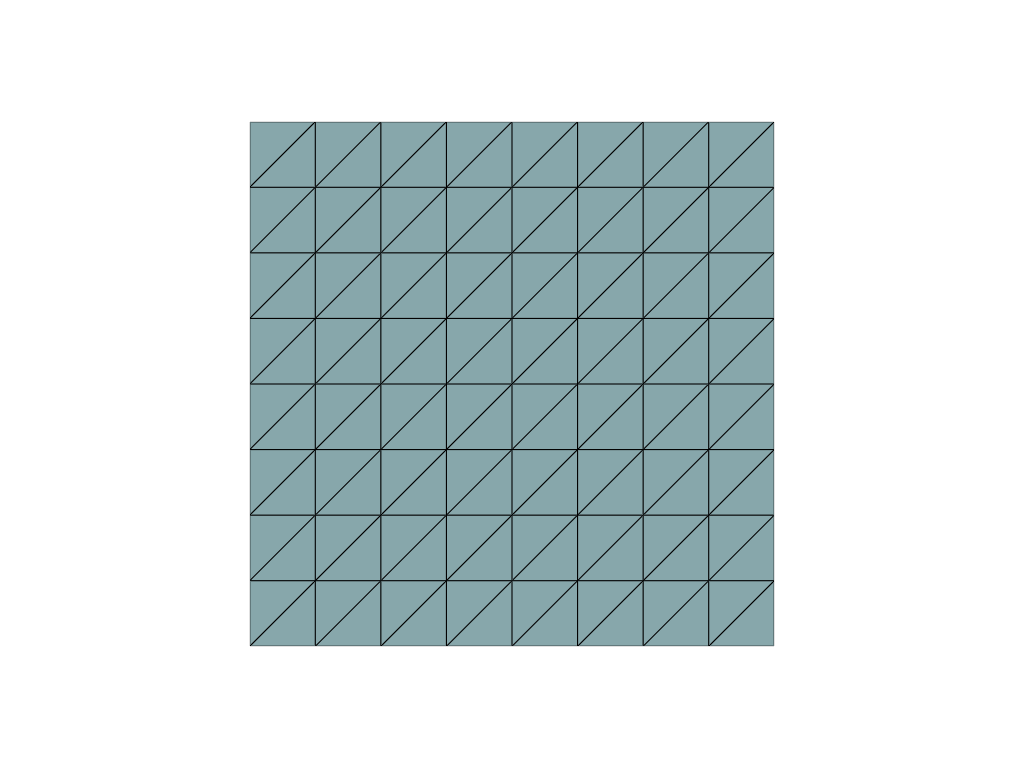

In [12]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("fundamentals_mesh.png")

In [13]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)

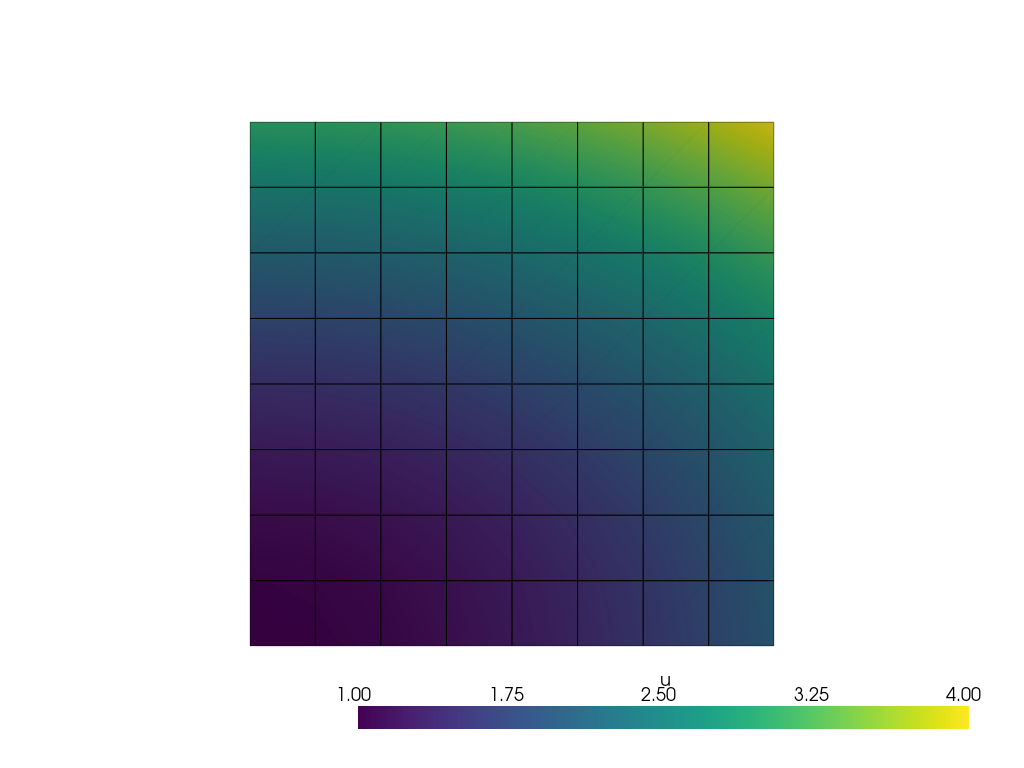

In [14]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

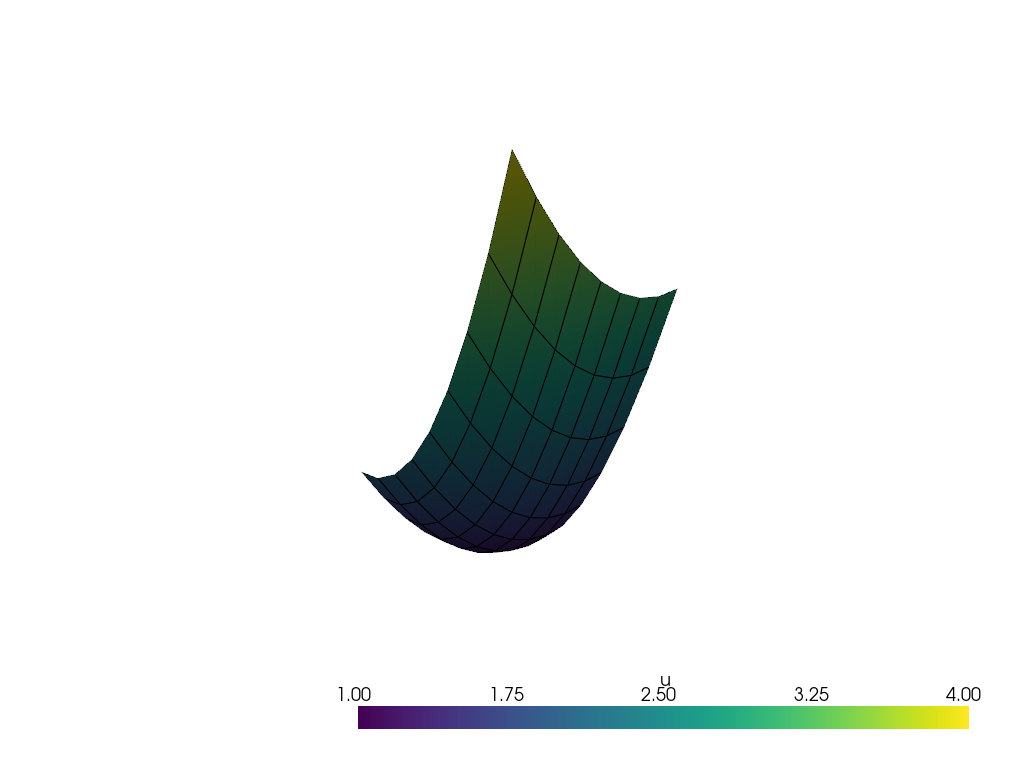

In [15]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()